# Zipline Backtest and Pyfolio Tearsheet with `momentum_pipeline.py` algo

This notebook shows how to run a Zipline backtest using the QuantRocket client then analyze the backtests results inside the notebook using pyfolio.

## Step 1: Collect Historical Data (skip if you already have data)
First, let's collect historical data for the backtest. (Typically you might use the command line to perform these steps, but they can also be performed using the Python client, and we show them here to make the notebook more self-contained.) 

The first step is to fetch some ETF listings.

In [3]:
from quantrocket.master import fetch_listings
symbols = ["SPY","EEM","GDX","VNQ","XLF","XOP"]
fetch_listings(exchange="ARCA", sec_types=["ETF"], symbols=symbols)

{'status': 'the listing details will be fetched asynchronously'}

Monitor flightlog for the listings to be fetched, then make a universe:

In [4]:
from quantrocket.master import download_master_file, create_universe
import io

# Download the listings we just fetched
f = io.StringIO()
download_master_file(f, exchanges=["ARCA"], sec_types=["ETF"], symbols=symbols)
# then create a universe
create_universe("etf-sampler", infilepath_or_buffer=f)

{'code': 'etf-sampler', 'inserted': 6, 'provided': 6, 'total_after_insert': 6}

Now create a history database and fetch the data:

In [5]:
from quantrocket.history import create_db, fetch_history
create_db("etf-sampler-1d", universes=["etf-sampler"], bar_size="1 day")

{'status': 'successfully created quantrocket.history.etf-sampler-1d.sqlite'}

In [6]:
fetch_history("etf-sampler-1d")

{'status': 'the historical data will be fetched asynchronously'}

Monitor flightlog for the historical data to be fetched, then move on to the next step, ingesting the data into Zipline.

## Step 2: Ingest Historical Data into Zipline
Next we ingest our history database into Zipline:

In [1]:
from quantrocket.zipline import ingest_bundle
ingest_bundle(history_db="etf-sampler-1d")

{'msg': 'successfully ingested etf-sampler-1d bundle', 'status': 'success'}

## Step 3: Run the Algo

In [2]:
from quantrocket.zipline import run_algorithm
import pandas as pd
import pyfolio as pf
import io

Next, run the backtest. We'll run the `momentum_pipeline.py` example file from the Zipline repository, which is included in QuantRocket's [codeload-demo GitHub repo](https://github.com/quantrocket-llc/codeload-demo/tree/master/zipline). 

QuantRocket returns the Zipline backtest results as a CSV. We write this CSV to an in-memory file then parse the file into a pandas DataFrame.

(Note that the backtest runs remotely on the zipline service, not inside the jupyter service, i.e. not in the notebook environment itself. QuantRocket's jupyter service doesn't support running Zipline backtests via the `%%zipline` extension.)

In [3]:
f = io.StringIO()
run_algorithm("momentum_pipeline.py", 
              bundle="etf-sampler-1d",
              start="2015-02-04", 
              end="2015-12-31",
              filepath_or_buffer=f)
results = pd.read_csv(f, parse_dates=["date"], index_col=["dataframe", "index", "date", "column"])["value"]

## Step 4: Create Tear Sheet

The CSV result file returned by `run_algorithm` contains several DataFrames stacked into one: the Zipline performance results, plus the extracted returns, transactions, positions, and benchmark returns from those results. We need to massage the returns, transactions, and positions back into the individual DataFrames (and data types) pyfolio expects.

Note that providing our benchmark returns to pyfolio is optional. If we don't do so, pyfolio will attempt to download benchmark data from a publicly available source.

In [4]:
# Extract returns
returns = results.loc["returns"].unstack()
returns.index = returns.index.droplevel(0).tz_localize("UTC")
returns = returns["returns"].astype(float)

# Extract positions
positions = results.loc["positions"].unstack()
positions.index = positions.index.droplevel(0).tz_localize("UTC")
positions = positions.astype(float)

# Extract transactions
transactions = results.loc["transactions"].unstack()
transactions.index = transactions.index.droplevel(0).tz_localize("UTC")
transactions = transactions.apply(pd.to_numeric, errors='ignore')

# Extract benchmark returns
benchmark_returns = results.loc["benchmark"].unstack()
benchmark_returns.index = benchmark_returns.index.droplevel(0).tz_localize("UTC")
benchmark_returns = benchmark_returns["benchmark"].astype(float)

Now we can generate our pyfolio tearsheet.

Entire data start date: 2015-02-06
Entire data end date: 2015-12-31
Backtest months: 10


,Backtest
Annual return,33.8%
Cumulative returns,30.2%
Annual volatility,20.5%
Sharpe ratio,1.53
Calmar ratio,2.75
Stability,0.78
Max drawdown,-12.3%
Omega ratio,1.28
Sortino ratio,2.42
Skew,0.20


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.30,2015-08-05,2015-09-22,NaT,NaN
1,5.52,2015-03-17,2015-03-26,2015-04-01,12
2,3.79,2015-04-16,2015-05-06,2015-07-01,55
3,2.40,2015-07-27,2015-07-29,2015-08-03,6
4,2.33,2015-03-09,2015-03-11,2015-03-16,6


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


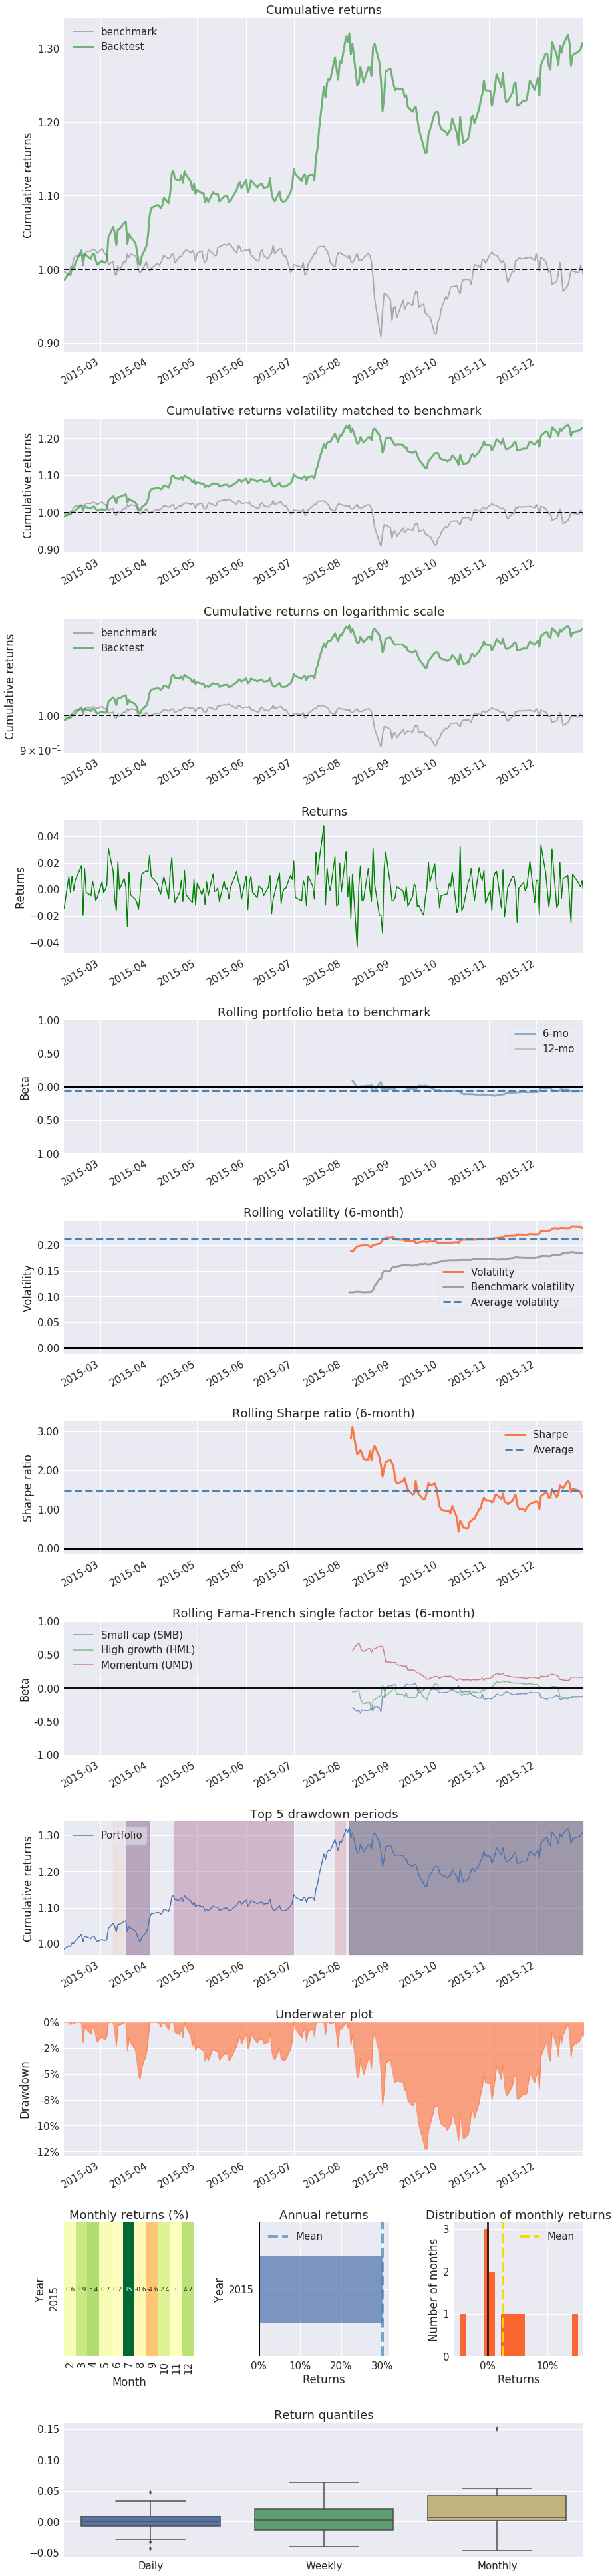

Stress Events,mean,min,max
Fall2015,-0.09%,-3.31%,3.09%
New Normal,0.12%,-4.34%,4.79%


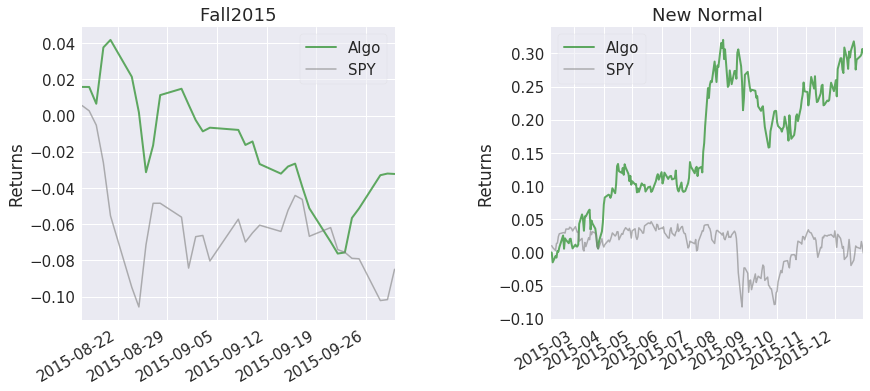

Top 10 long positions of all time,max
column,
Equity(31230302 [VNQ]),66.03%
Equity(45540782 [XOP]),49.21%
Equity(229726316 [GDX]),41.17%
Equity(4215220 [XLF]),35.18%
Equity(6604766 [EEM]),34.71%
Equity(756733 [SPY]),34.71%


Top 10 short positions of all time,max
column,
Equity(45540782 [XOP]),-75.69%
Equity(31230302 [VNQ]),-53.99%
Equity(229726316 [GDX]),-43.17%
Equity(756733 [SPY]),-35.80%
Equity(4215220 [XLF]),-35.78%
Equity(6604766 [EEM]),-35.61%


Top 10 positions of all time,max
column,
Equity(45540782 [XOP]),75.69%
Equity(31230302 [VNQ]),66.03%
Equity(229726316 [GDX]),43.17%
Equity(756733 [SPY]),35.80%
Equity(4215220 [XLF]),35.78%
Equity(6604766 [EEM]),35.61%


All positions ever held,max
column,
Equity(45540782 [XOP]),75.69%
Equity(31230302 [VNQ]),66.03%
Equity(229726316 [GDX]),43.17%
Equity(756733 [SPY]),35.80%
Equity(4215220 [XLF]),35.78%
Equity(6604766 [EEM]),35.61%


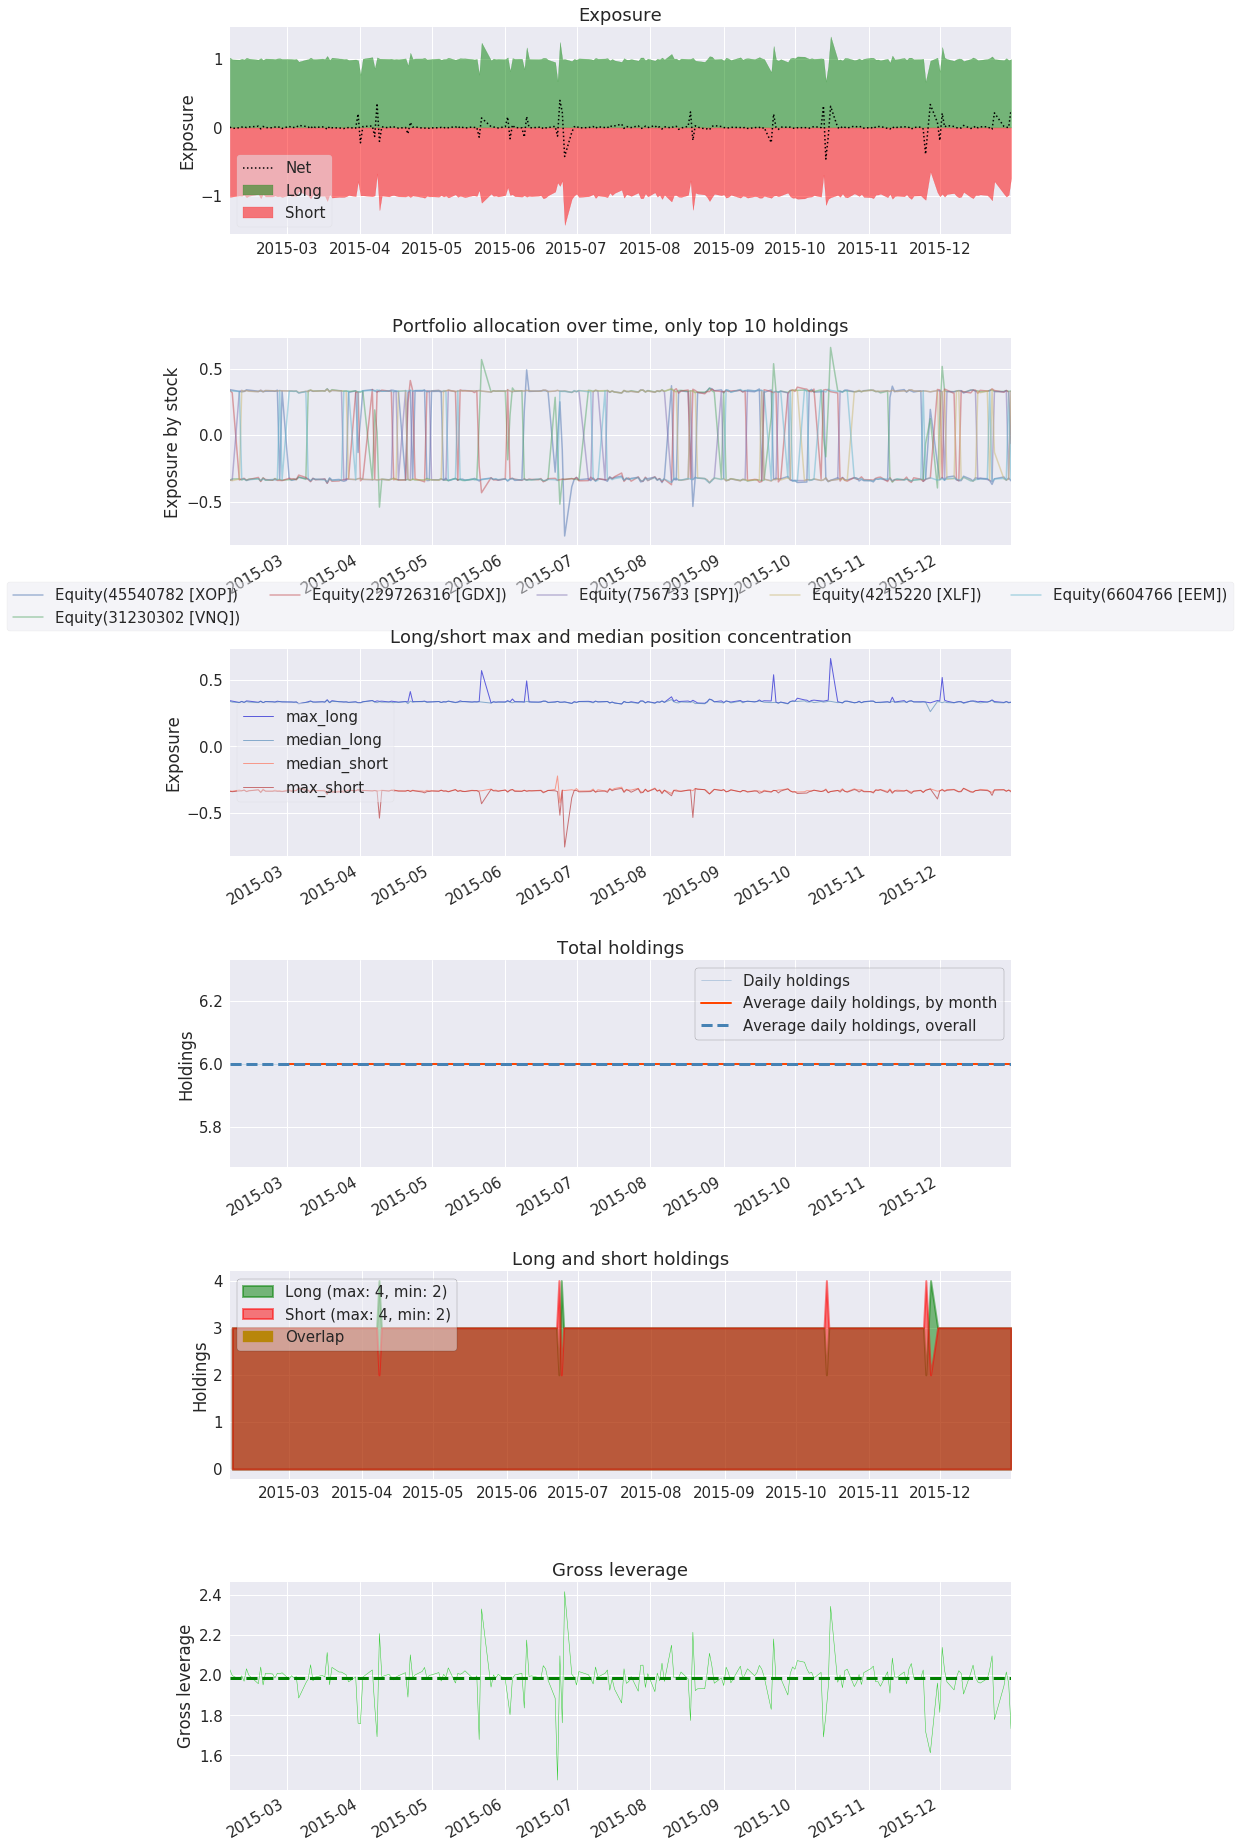

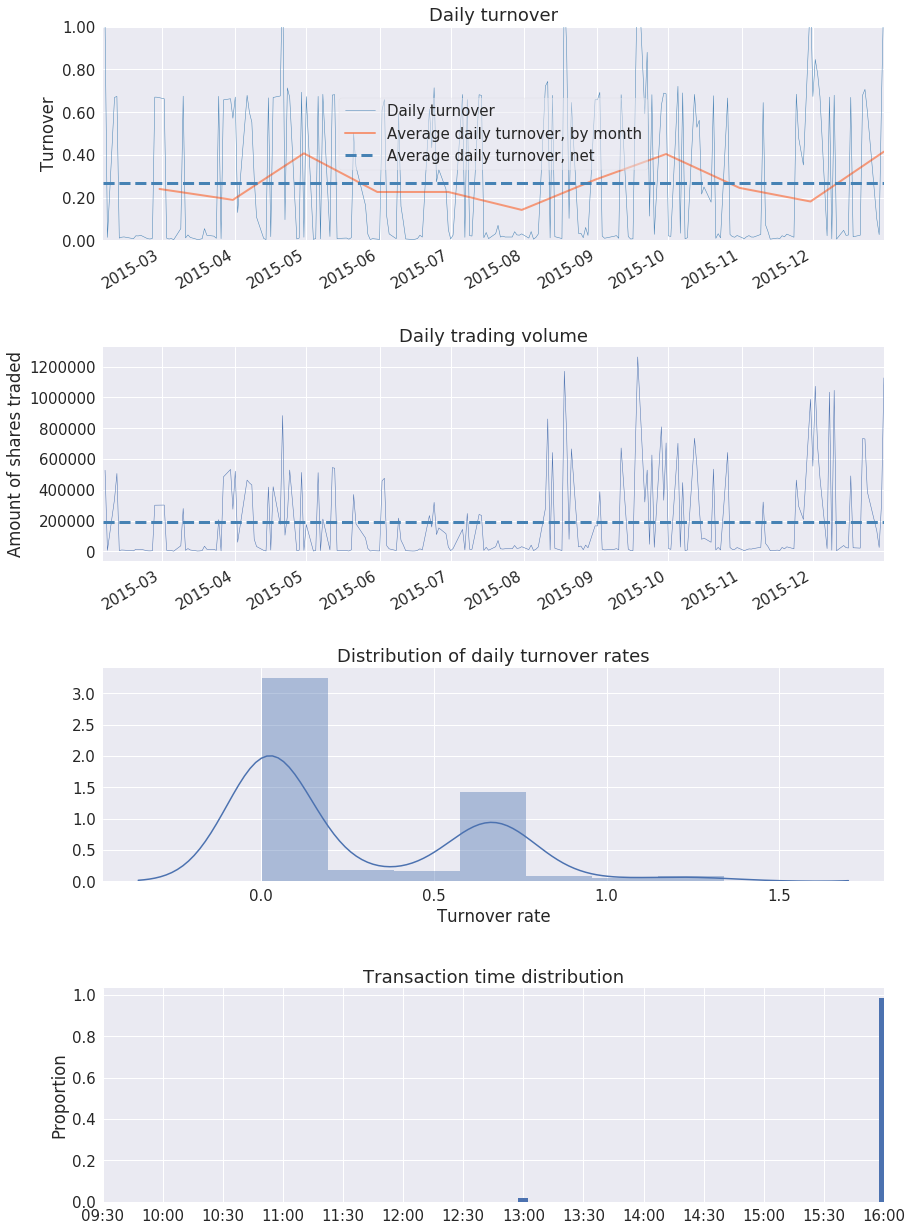

In [5]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=benchmark_returns)

## Analyze your backtest results  

If you want to explore the Zipline backtest results directly, you can do that as well. 

In [6]:
perf = results.loc["perf"].unstack()
perf.index = perf.index.droplevel(0).tz_localize("UTC")
perf = perf.apply(pd.to_numeric, errors='ignore')
print(perf.head())

column                     algo_volatility  algorithm_period_return     alpha  \
date                                                                            
2015-02-04 00:00:00+00:00              NaN                 0.000000       NaN   
2015-02-05 00:00:00+00:00         0.004567                -0.000407 -0.028079   
2015-02-06 00:00:00+00:00         0.132510                -0.015058 -1.398855   
2015-02-09 00:00:00+00:00         0.158897                -0.005563 -0.345052   
2015-02-10 00:00:00+00:00         0.137807                -0.007946 -0.359151   

column                     benchmark_period_return  benchmark_volatility  \
date                                                                       
2015-02-04 00:00:00+00:00                -0.003808                   NaN   
2015-02-05 00:00:00+00:00                 0.006249              0.156060   
2015-02-06 00:00:00+00:00                 0.003466              0.122924   
2015-02-09 00:00:00+00:00                -0.001025  